In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_style('whitegrid')

In [2]:
metrics = pd.read_csv('../logs/lightning_logs/version_18/metrics.csv')
metrics.head(2)

,step,train_loss,epoch,val_loss_step,val_loss_epoch,val_accuracy,train_accuracy
0,99,3.85961,0.0,NaN,NaN,NaN,NaN
1,0,NaN,NaN,3.775011,NaN,NaN,NaN


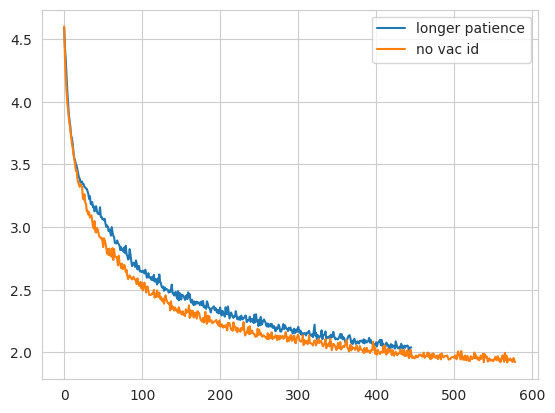

In [3]:
metrics = pd.read_csv('../logs/lightning_logs/version_47/metrics.csv')
val_loss = metrics[['step', 'val_loss_epoch']].dropna()
val_loss['g'] = val_loss['step'] // 100
val_loss = val_loss.groupby('g')['val_loss_epoch'].mean()
plt.plot(val_loss.index, val_loss, label='longer patience')

metrics = pd.read_csv('../logs/lightning_logs/version_49/metrics.csv')
val_loss = metrics[['step', 'val_loss_epoch']].dropna()
val_loss['g'] = val_loss['step'] // 100
val_loss = val_loss.groupby('g')['val_loss_epoch'].mean()
plt.plot(val_loss.index, val_loss, label='no vac id')

plt.legend()
plt.show()

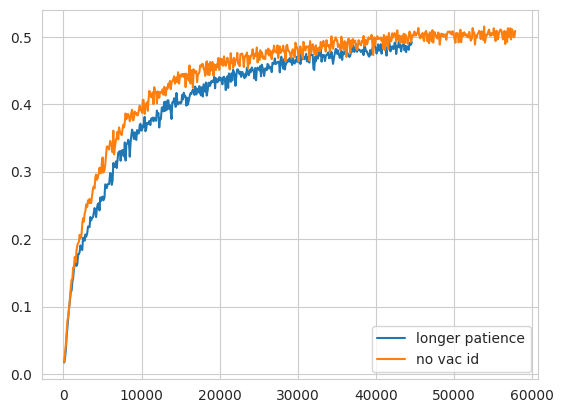

In [4]:
metrics = pd.read_csv('../logs/lightning_logs/version_47/metrics.csv')
val_accuracy = metrics[['epoch', 'step', 'val_accuracy']].dropna()
plt.plot(val_accuracy['step'], val_accuracy['val_accuracy'], label='longer patience')

metrics = pd.read_csv('../logs/lightning_logs/version_49/metrics.csv')
val_accuracy = metrics[['epoch', 'step', 'val_accuracy']].dropna()
plt.plot(val_accuracy['step'], val_accuracy['val_accuracy'], label='no vac id')

plt.legend()
plt.show()

In [7]:
import polars as pl

In [8]:
x = pl.read_parquet('../data/dssm_train.pq')
x.head(2)

user_id,n_sessions,vacancy_id,action_type,is_test,target,session_id,session_end
str,u32,list[u64],list[i64],bool,u64,str,datetime[ns]
"""u_680055""",2,"[933942, 1615677, 1759260]","[2, 2, 2]",false,1553772,"""s_25331006""",2023-11-02 10:22:42.262
"""u_634780""",8,"[781804, 439523, … 228999]","[2, 2, … 2]",false,2160082,"""s_14127949""",2023-11-14 10:45:44.444


In [10]:
x['vacancy_id'].explode()

vacancy_id
u64
933942
1615677
1759260
781804
439523
1569445
1821602
1142413
2589189


## Загрузка модели

In [1]:
!ls ../data | grep ckpt

epoch=1-step=11169.ckpt
epoch=1-step=13269.ckpt


In [2]:
from hh.dssm import (
    DSSM,
    EmbedMultipleVac,
    EmbedSingleVac,
    VacancyDescription,
)
import torch
from sklearn import manifold

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import polars as pl

import hnswlib

sns.set_style('whitegrid')

In [3]:
description = VacancyDescription(path='../data/vacancy_features.pq')
dssm = DSSM(
    embed_x=EmbedMultipleVac(description=description),
    embed_y=EmbedSingleVac(description=description),
)
dssm = DSSM.load_from_checkpoint(
    '../data/epoch=1-step=13269.ckpt',
    embed_x=EmbedMultipleVac(description=description),
    embed_y=EmbedSingleVac(description=description),
)

In [116]:
dssm

DSSM(
  (embed_x): EmbedMultipleVac(
    (vacancy_id_embed): EmbeddingBag(2734130, 32, mode='mean')
    (company_id): EmbeddingBag(278913, 16, mode='mean')
    (area_id): EmbeddingBag(7015, 16, mode='mean')
    (area_region_id): EmbeddingBag(107, 8, mode='mean')
    (employment): EmbeddingBag(6, 4, mode='mean')
    (work_schedule): EmbeddingBag(6, 4, mode='mean')
    (work_experience): EmbeddingBag(5, 4, mode='mean')
    (compensation_currency_code): EmbeddingBag(11, 4, mode='mean')
    (name): EmbeddingBag(18060, 16, mode='mean')
    (fc): Linear(in_features=104, out_features=64, bias=True)
  )
  (embed_y): EmbedSingleVac(
    (vacancy_id_embed): Embedding(2734130, 32)
    (company_id): Embedding(278913, 16)
    (area_id): Embedding(7015, 16)
    (area_region_id): Embedding(107, 8)
    (employment): Embedding(6, 4)
    (work_schedule): Embedding(6, 4)
    (work_experience): Embedding(5, 4)
    (compensation_currency_code): Embedding(11, 4)
    (name): Embedding(18060, 16)
    (fc): Li

In [147]:
vacs = torch.arange(0, description.company_id.shape[0], dtype=torch.long)

In [148]:
description.name = description.name.clip(max=18059)

In [149]:
vac_embeddings = dssm.embed_y(vacs)

In [150]:
x = vac_embeddings.detach().cpu().numpy()
x.shape

(2734130, 64)

In [151]:
y = manifold.TSNE().fit_transform(x[:1000])
y.shape

(1000, 2)

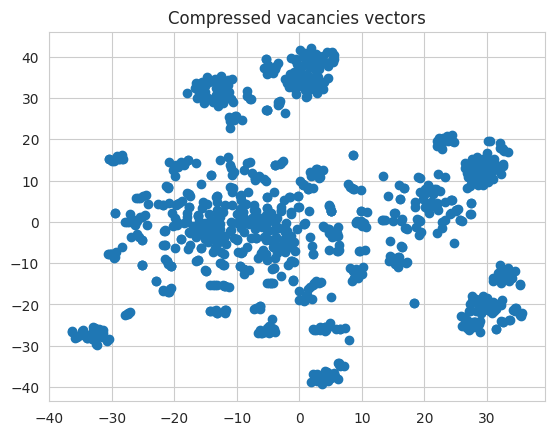

In [152]:
plt.scatter(y[:, 0], y[:, 1])
plt.title('Compressed vacancies vectors')
plt.show()

In [153]:
# users_df = pl.read_parquet('../data/user_application_features.pq')
users_df = pl.read_parquet('../data/dssm_train.pq')
users_df.head(2)

user_id,n_sessions,vacancy_id,action_type,is_test,session_id,session_end,target
str,u32,list[u64],list[i64],bool,str,datetime[ns],u64
"""u_237129""",2,"[1481580, 208271, … 1606798]","[2, 2, … 2]",false,"""s_361359""",2023-11-13 12:08:36.976,716724
"""u_237129""",2,"[1481580, 208271, … 1606798]","[2, 2, … 2]",false,"""s_361359""",2023-11-13 12:08:36.976,690666


In [154]:
HISTORY_LENGTH = 16

def _pad(seqs):
    def pad_seq(seq):
        seq = seq[:HISTORY_LENGTH]
        return seq + [0] * (HISTORY_LENGTH - len(seq))
    return [pad_seq(seq) for seq in seqs]
users_tensor = torch.tensor(_pad(users_df['vacancy_id'].to_list()), dtype=torch.long)
users_tensor.shape

torch.Size([348698, 16])

In [155]:
target_tensor = torch.tensor(users_df['target'].to_list())
target_tensor.shape

torch.Size([348698])

In [156]:
batch_size = 32
batch = users_tensor[:batch_size], target_tensor[:batch_size]
logits = dssm(*batch)

In [157]:
(logits.argmax(axis=0) == torch.arange(0, batch_size)).float().mean()

tensor(0.2188)

In [158]:
user_embeddings = dssm.embed_x(users_tensor).detach().cpu().numpy()

In [159]:
logits[0, 0]

tensor(7.0255, grad_fn=<SelectBackward0>)

In [162]:
(user_embeddings[0] * x[targets[0]]).sum()

7.025489

In [163]:
(user_embeddings * x[targets - 1]).mean()

0.0027159466

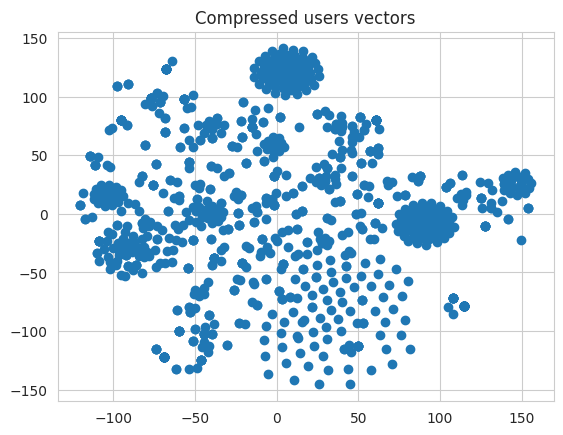

In [164]:
uy = manifold.TSNE().fit_transform(user_embeddings[:1000])
plt.scatter(uy[:, 0], uy[:, 1])
plt.title('Compressed users vectors')
plt.show()

In [174]:
def cos(a, b):
    return (1 - (a * b).sum() / np.linalg.norm(a) / np.linalg.norm(b)) / 2


In [165]:
%%time

num_elements, dim = x.shape

ids = np.arange(num_elements)

# Declaring index
p = hnswlib.Index(space = 'ip', dim = dim) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements=num_elements, ef_construction=400, M=16)

# Element insertion (can be called several times):
p.add_items(x, ids)


CPU times: user 40min 44s, sys: 10.8 s, total: 40min 55s
Wall time: 3min 59s


In [166]:
%%time

# Controlling the recall by setting ef:
p.set_ef(200) # ef should always be > k

# Query dataset, k - number of the closest elements (returns 2 numpy arrays)
labels, distances = p.knn_query(user_embeddings, k = 100)

CPU times: user 1min 57s, sys: 1.37 s, total: 1min 58s
Wall time: 11.1 s


In [22]:
targets = np.array(users_df['target'].to_list())

In [172]:
is_test = np.array(users_df['is_test'].to_list())

In [173]:
(labels[is_test] == targets[is_test, None]).sum()

429

In [175]:
ts, cs = np.unique(targets, return_counts=True)

In [182]:
cs.sum(), cs[cs > 10].sum()

(348698, 57901)

In [177]:
goodts = ts[cs > 10]
goodts.shape

(2956,)

In [178]:
%%time

num_elements, dim = goodts.shape[0], x.shape[1]

ids = goodts

# Declaring index
p = hnswlib.Index(space='ip', dim=dim) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements=num_elements, ef_construction=400, M=16)

# Element insertion (can be called several times):
p.add_items(x[goodts], ids)


CPU times: user 1.04 s, sys: 180 ms, total: 1.22 s
Wall time: 535 ms


In [179]:
%%time

# Controlling the recall by setting ef:
p.set_ef(200) # ef should always be > k

# Query dataset, k - number of the closest elements (returns 2 numpy arrays)
labels, distances = p.knn_query(user_embeddings, k = 100)

CPU times: user 40.7 s, sys: 657 ms, total: 41.3 s
Wall time: 3.89 s


In [181]:
(labels == targets[:, None]).sum()

12816

In [214]:
for th in [10, 5, 4, 3, 2, 1, 0]:
    goodts = ts[cs >= th]
    p = hnswlib.Index(space='ip', dim=dim)
    p.init_index(max_elements=goodts.shape[0], ef_construction=400, M=16)
    p.add_items(x[goodts], goodts)
    labels, distances = p.knn_query(user_embeddings, k = 200)
    n_matches = (labels[is_test] == targets[is_test, None]).sum()
    print(f'Threshold: {th}, n_matches: {n_matches}')


Threshold: 10, n_matches: 2635
Threshold: 5, n_matches: 2912
Threshold: 4, n_matches: 3046
Threshold: 3, n_matches: 3218
Threshold: 2, n_matches: 3512
Threshold: 1, n_matches: 3310
Threshold: 0, n_matches: 3309


In [213]:
for th in [10, 5, 4, 3, 2, 1, 0]:
    goodts = ts[cs >= th]
    p = hnswlib.Index(space='ip', dim=dim)
    p.init_index(max_elements=goodts.shape[0], ef_construction=400, M=16)
    p.add_items(x[goodts], goodts)
    labels, distances = p.knn_query(user_embeddings, k = 100)
    n_matches = (labels[is_test] == targets[is_test, None]).sum()
    print(f'Threshold: {th}, n_matches: {n_matches}')


Threshold: 10, n_matches: 1770
Threshold: 5, n_matches: 1979
Threshold: 4, n_matches: 2068
Threshold: 3, n_matches: 2206
Threshold: 2, n_matches: 2335
Threshold: 1, n_matches: 2019
Threshold: 0, n_matches: 2015


In [210]:
users_df.filter(pl.col('is_test')).group_by('user_id').count().count()

user_id,count
u32,u32
15526,15526


In [205]:
((labels == targets[:, None]) / np.arange(1, 101)).sum(axis=1)[is_test].mean()

0.0034207116439865315

In [228]:
pl.DataFrame().with_columns(
    users_df['user_id'],
    dssm=labels,
    dssm_distances=distances,
).select(
    pl.col('dssm'),
    pl.col('dssm_distances'),
    pl.col('user_id').cast(pl.String),
)

dssm,dssm_distances,user_id
list[u64],list[f32],str
"[1009738, 40873, … 1403852]","[-7.823747, -7.814659, … -6.208184]","""u_237129"""
"[1009738, 40873, … 1403852]","[-7.823747, -7.814659, … -6.208184]","""u_237129"""
"[2702506, 407412, … 2457430]","[-3.097103, -2.984145, … -2.236562]","""u_864547"""
"[2702506, 407412, … 2457430]","[-3.097103, -2.984145, … -2.236562]","""u_864547"""
"[172073, 56614, … 636499]","[-3.209113, -3.062974, … -2.61508]","""u_67865"""
"[172073, 56614, … 636499]","[-3.209113, -3.062974, … -2.61508]","""u_67865"""
"[1005608, 542654, … 983755]","[-2.740745, -2.649535, … -2.230035]","""u_408815"""
"[1005608, 542654, … 983755]","[-2.740745, -2.649535, … -2.230035]","""u_408815"""
"[1005608, 542654, … 983755]","[-2.740745, -2.649535, … -2.230035]","""u_408815"""


In [62]:
import polars as pl

from hh import utils

In [3]:
!ls ../data

 d_history_plus_dssm.pq     history_plus_dssm.pq
 dssm_prediction.pq	    test.fth
 dssm_test_prediction.pq    train.fth
 dssm_train.pq		    train.sample.fth
'epoch=1-step=11169.ckpt'   train.small_sample.fth
'epoch=1-step=13269.ckpt'   train_dataset.fth
 hh_recsys_sample.pq	    train_dataset.sample.fth
 hh_recsys_test_hh.pq	    user_application_features.pq
 hh_recsys_train_hh.pq	    vac.no_desc.fth
 hh_recsys_vacancies.pq     vacancy_features.pq
 history_baseline.pq


In [7]:
b = pl.read_parquet('../data/history_baseline.pq')
b.head(3)

user_id,predictions
str,list[str]
"""u_828064""","[""v_21361"", ""v_1642325"", … ""v_1770705""]"
"""u_850674""","[""v_1602597"", ""v_1802097"", … ""v_420479""]"
"""u_67292""","[""v_257694"", ""v_1369548"", ""v_1768728""]"


In [81]:
d = pl.read_parquet('../data/history_plus_dssm.pq')
d.head(3)

user_id,predictions
str,list[str]
"""u_172881""","[""v_156606"", ""v_77234"", … ""v_1664723""]"
"""u_450290""","[""v_982833"", ""v_1101770"", … ""v_890877""]"
"""u_181821""","[""v_2372948"", ""v_627858"", … ""v_237331""]"


In [10]:
b.filter(
    pl.col('user_id') == 'u_862191'
)

user_id,predictions
str,list[str]
"""u_862191""","[""v_2659331"", ""v_2618190"", … ""v_1350016""]"


In [23]:
log = pl.concat([
    pl.read_parquet('../data/hh_recsys_train_hh.pq'),
    pl.read_parquet('../data/hh_recsys_test_hh.pq'),
]).select(
    pl.all(),
    pl.col('action_dt').list.max().alias('session_end_dt'),
)
log.head(3)

user_id,session_id,vacancy_id,action_type,action_dt,session_end_dt
str,str,list[str],list[i64],list[datetime[ns]],datetime[ns]
"""u_332060""","""s_28301374""","[""v_2571684"", ""v_488179"", … ""v_2633899""]","[2, 2, … 2]","[2023-11-01 00:40:58.105, 2023-11-01 00:58:13.091, … 2023-11-01 01:35:54.456]",2023-11-01 01:50:26.158
"""u_1057881""","""s_33868982""","[""v_665861""]",[2],[2023-11-01 00:23:51.452],2023-11-01 00:23:51.452
"""u_1036784""","""s_32474802""","[""v_2594840""]",[2],[2023-11-01 00:52:34.023],2023-11-01 00:52:34.023


In [34]:
last_sessions = log.sort('session_end_dt', descending=True).group_by(
    'user_id'
).agg(
    pl.col('session_end_dt'),
    pl.cum_count().alias('idx'),
).select(
    'user_id',
    pl.col('session_end_dt').list.head(10).alias('last_sessions'),
    pl.col('idx').list.head(10),
)

last_sessions.head(2)

user_id,last_sessions,idx
str,list[datetime[ns]],list[u32]
"""u_358442""",[2023-11-14 00:12:14.185],[1]
"""u_1112283""","[2023-11-09 13:22:37.792, 2023-11-02 17:39:51.660]","[1, 2]"


In [35]:
j = log.select(
    'user_id',
    'session_end_dt',
    'vacancy_id',
).explode(
    'vacancy_id',
).join(
    last_sessions,
    on='user_id'
)
j.head(2)

user_id,session_end_dt,vacancy_id,last_sessions,idx
str,datetime[ns],str,list[datetime[ns]],list[u32]
"""u_332060""",2023-11-01 01:50:26.158,"""v_2571684""","[2023-11-13 20:24:53.544, 2023-11-08 18:14:41.305, … 2023-11-01 01:50:26.158]","[1, 2, … 4]"
"""u_332060""",2023-11-01 01:50:26.158,"""v_488179""","[2023-11-13 20:24:53.544, 2023-11-08 18:14:41.305, … 2023-11-01 01:50:26.158]","[1, 2, … 4]"


In [42]:
j.explode(
    'idx',
    'last_sessions',
).filter(
    pl.col('session_end_dt') == pl.col('last_sessions'),
).group_by(
    'user_id',
    'vacancy_id'
).agg(
    pl.col('idx').min().alias('sessions_back'),
)

user_id,vacancy_id,sessions_back
str,str,u32
"""u_332060""","""v_518327""",4
"""u_332060""","""v_2191653""",4
"""u_788103""","""v_2028948""",2
"""u_788103""","""v_2212319""",2
"""u_233628""","""v_1071884""",2
"""u_233628""","""v_521122""",2
"""u_233628""","""v_1404634""",2
"""u_229914""","""v_1335916""",1
"""u_229914""","""v_998760""",1


In [13]:
vacs = pl.read_parquet('../data/hh_recsys_vacancies.pq').select(pl.exclude('description', 'keySkills.keySkill'))

In [14]:
vacs.head(2)

vacancy_id,name,company.id,compensation.from,compensation.to,compensation.currencyCode,area.id,area.regionId,employment,workSchedule,workExperience
str,str,str,i64,i64,str,str,str,str,str,str
"""v_862116""","""Смотритель муз…","""c_162972""",16500,null,"""RUR""","""a_4761""","""ar_33""","""full""","""fullDay""","""noExperience"""
"""v_288642""","""Ведущий менедж…","""c_208672""",50000,null,"""RUR""","""a_744""","""ar_2""","""full""","""fullDay""","""noExperience"""


In [15]:
vac_features = vacs.select(
    pl.col('vacancy_id'),
    pl.col('name'),
    pl.col('company.id'),
    pl.col('area.id'),
    pl.col('employment'),
    pl.col('workSchedule'),
    pl.col('workExperience'),
)

In [24]:
pl.read_parquet('../data/final_train_dataset.pq').head(3)

user_id,vacancy_id,likes_count,applies_count,views_count,likes_back,applies_back,views_back,score,score_pos,name,company.id,compensation.from,compensation.to,compensation.currencyCode,area.id,area.regionId,employment,workSchedule,workExperience,eq_name,eq_company.id,eq_area.id,eq_employment,eq_workSchedule,eq_workExperience,is_test,target
str,str,u32,u32,u32,i64,i64,i64,f32,i64,str,str,i64,i64,str,str,str,str,str,str,u32,u32,u32,u32,u32,u32,bool,i64
"""u_1170040""","""v_1596447""",0,0,2,1000,1000,82,10.0,1000,"""Руководитель о…","""c_134540""",70000,200000,"""RUR""","""a_6298""","""ar_96""","""full""","""fullDay""","""between3And6""",18,2,325,511,303,119,false,1
"""u_641082""","""v_1743984""",0,0,2,1000,1000,65,10.0,1000,"""Frontend devel…","""c_90944""",null,null,null,"""a_6223""","""ar_78""","""full""","""fullDay""","""between1And3""",4,8,68,223,154,91,false,1
"""u_522374""","""v_1616899""",0,0,1,1000,1000,16,10.0,1000,"""Специалист кон…","""c_263133""",103500,null,"""RUR""","""a_3342""","""ar_64""","""full""","""shift""","""between1And3""",1,1,28,26,2,16,false,1


In [18]:
flog = log.join(
    vac_features,
    on='vacancy_id',
)
len(log), len(flog)

(22063712, 22063712)

In [23]:
feature = 'area.id'
flog.group_by(
    pl.col('user_id'),
    pl.col(feature),
).count().select(
    pl.exclude('count'),
    pl.col('count').alias(f'eq_{feature}')
)

user_id,area.id,eq_area.id
str,str,u32
"""u_533214""","""a_5154""",1
"""u_699440""","""a_6223""",69
"""u_962277""","""a_6223""",9
"""u_913301""","""a_1756""",43
"""u_875004""","""a_1756""",4
"""u_26669""","""a_3756""",1
"""u_754399""","""a_1756""",6
"""u_171237""","""a_5398""",3
"""u_847226""","""a_1756""",14


In [69]:
likes = log.filter(
    pl.col('action_type') == 3,
).group_by(
    'user_id',
).agg(
    pl.col('vacancy_id').alias('likes'),
)
likes.head(3)

user_id,likes
str,list[str]
"""u_66687""","[""v_1162244"", ""v_120842"", … ""v_1188493""]"
"""u_657355""","[""v_216258"", ""v_2279628"", … ""v_812771""]"
"""u_683452""","[""v_580530""]"


In [70]:
views = log.filter(
    pl.col('action_type') == 2,
).group_by(
    'user_id',
).agg(
    pl.col('vacancy_id').alias('views'),
)
views.head(3)

user_id,views
str,list[str]
"""u_653282""","[""v_447369"", ""v_2529975"", … ""v_1882081""]"
"""u_389350""","[""v_1170768"", ""v_2125779"", … ""v_368551""]"
"""u_611165""","[""v_733052"", ""v_436310"", … ""v_1318921""]"


In [71]:
applies = log.filter(
    pl.col('action_type') == 1,
).group_by(
    'user_id',
).agg(
    pl.col('vacancy_id').alias('applies'),
)
applies.head(3)

user_id,applies
str,list[str]
"""u_735061""","[""v_1550357"", ""v_120393"", … ""v_290425""]"
"""u_809799""","[""v_683089"", ""v_454980"", … ""v_1682299""]"
"""u_169713""","[""v_2304039"", ""v_2253216""]"


In [72]:
%%time
dssm = pl.read_parquet('../data/dssm_prediction.pq').select(
    pl.col('user_id'),
    pl.col('dssm'),
)
print(dssm['dssm'].list.len().unique())
dssm.head()

shape: (1,)
Series: 'dssm' [u32]
[
	200
]
CPU times: user 20.5 s, sys: 8.87 s, total: 29.4 s
Wall time: 20.2 s


user_id,dssm
str,list[str]
"""u_20816""","[""v_1694818"", ""v_2498568"", … ""v_247290""]"
"""u_417210""","[""v_1108265"", ""v_814288"", … ""v_2691686""]"
"""u_713655""","[""v_1694818"", ""v_2498568"", … ""v_1112428""]"
"""u_199982""","[""v_2498568"", ""v_1694818"", … ""v_2217175""]"
"""u_483444""","[""v_1853938"", ""v_1745542"", … ""v_904167""]"


In [73]:
needed = pl.read_parquet('../data/hh_recsys_test_hh.pq').select(
    pl.col('user_id')
).unique()
print(len(needed))
needed.head()

83189


user_id
str
"""u_384954"""
"""u_112410"""
"""u_168258"""
"""u_37049"""
"""u_404817"""


In [74]:
%%time
res = needed.join(
    likes,
    on='user_id',
    how='left',
).join(
    applies,
    on='user_id',
    how='left',
).join(
    views,
    on='user_id',
    how='left',
).join(
    dssm,
    on='user_id',
    how='left',
).select(
    pl.col('user_id'),
    pl.col('likes').fill_null([]),
    pl.col('applies').fill_null([]),
    pl.col('views').fill_null([]),
    pl.col('dssm').fill_null([]),
)

res.head(3)

CPU times: user 868 ms, sys: 476 ms, total: 1.34 s
Wall time: 808 ms


user_id,likes,applies,views,dssm
str,list[str],list[str],list[str],list[str]
"""u_384954""",[],"[""v_1564592"", ""v_23199"", … ""v_2557303""]","[""v_1564592"", ""v_432069"", … ""v_1734824""]","[""v_2235500"", ""v_2303737"", … ""v_1113235""]"
"""u_112410""",[],"[""v_2730052"", ""v_608354""]","[""v_593272"", ""v_2730052"", … ""v_86011""]","[""v_761006"", ""v_115110"", … ""v_43083""]"
"""u_168258""",[],"[""v_697541""]","[""v_1438469"", ""v_2175269"", … ""v_1438469""]","[""v_219610"", ""v_2685643"", … ""v_2360592""]"


In [75]:
p = res.select(
    pl.col('user_id'),
    pl.concat_list([
        pl.col('likes').list.set_difference('applies'),
        pl.col('views').list.set_difference('applies'),
        pl.col('dssm').list.set_difference('applies'),
    ]).list.unique(maintain_order=True).list.head(100).alias('predictions'),
)
p.head()

user_id,predictions
str,list[str]
"""u_384954""","[""v_1273010"", ""v_432069"", … ""v_231532""]"
"""u_112410""","[""v_593272"", ""v_86011"", … ""v_160657""]"
"""u_168258""","[""v_1438469"", ""v_2175269"", … ""v_1991536""]"
"""u_37049""","[""v_2026085"", ""v_1054000"", … ""v_905489""]"
"""u_404817""","[""v_656167"", ""v_580809"", … ""v_1019669""]"


In [82]:
d.filter(pl.col('user_id') == 'u_962054')

user_id,predictions
str,list[str]
"""u_962054""","[""v_739772"", ""v_1307295"", … ""v_58846""]"


In [83]:
p.filter(pl.col('user_id') == 'u_962054')

user_id,predictions
str,list[str]
"""u_962054""","[""v_739772"", ""v_1307295"", … ""v_58846""]"


In [80]:
 utils.save_pq(
    p,
    '../data/dssm_prediction_v2.pq'
)

Writing Dataframe to ../data/dssm_prediction_v2.pq


In [88]:
pl.read_parquet('../data/dssm_prediction.pq').head(2)

dssm,dssm_distances,user_id
list[str],list[f32],str
"[""v_1694818"", ""v_2498568"", … ""v_247290""]","[-2.706437, -2.675928, … -1.739868]","""u_20816"""
"[""v_1108265"", ""v_814288"", … ""v_2691686""]","[-2.412419, -2.397447, … -2.038765]","""u_417210"""


In [6]:
import polars as pl

In [78]:
train = pl.read_parquet('../data/final_train_dataset.pq')
train.head(2)

user_id,session_id,is_test,target,likes,applies,views,dssm,dssm_distances
str,str,bool,list[str],list[str],list[str],list[str],list[str],list[f32]
"""u_748259""","""s_27139201""",false,"[""v_1553355"", ""v_2586325""]",[],"[""v_2172718"", ""v_615640""]","[""v_2172718"", ""v_565858"", … ""v_661999""]","[""v_1535927"", ""v_223717"", … ""v_1216527""]","[-3.508896, -3.482741, … -2.563688]"
"""u_1146665""","""s_4482386""",false,"[""v_1859845"", ""v_1974520"", … ""v_1330344""]",[],"[""v_340620"", ""v_2418831"", … ""v_2""]","[""v_2363849"", ""v_294472"", … ""v_2""]","[""v_2364193"", ""v_1096452"", … ""v_116633""]","[-2.39631, -2.374844, … -1.629629]"


In [79]:
train.group_by(
    'session_id',
).count().sort('count', descending=True).head(3)

session_id,count
str,u32
"""s_29872891""",13
"""s_11977678""",6
"""s_1068329""",5


In [80]:
len(train['user_id'].unique()), len(train)

(109586, 109586)

In [5]:
views, applies, likes = [train.select(
    pl.col('user_id'),
    pl.col(action),
    pl.col(action).list.len().map_elements(
        lambda s: list(range(s)),
        return_dtype=pl.List(pl.Int64),
    ).alias(f'{action}_back'),
).explode(
    action,
    f'{action}_back',
).filter(
    pl.col(action).is_not_null(),
).group_by(
    'user_id',
    pl.col(action).alias('vacancy_id'),
).agg(
    pl.count().alias(f'{action}_count'),
    pl.col(f'{action}_back').min(),
) for action in ['views', 'applies', 'likes']]

views.head(2)

user_id,vacancy_id,views_count,views_back
str,str,u32,i64
"""u_748259""","""v_796909""",1,6
"""u_1146665""","""v_2363849""",2,0


In [6]:
train['dssm'].list.len().unique()

dssm
u32
200


In [7]:
dssm = train.select(
    pl.col('user_id'),
    pl.col('dssm').alias('vacancy_id'),
    pl.col('dssm_distances').alias('score'),
    pl.lit(list(range(200))).alias('score_pos'),
).explode(
    'vacancy_id',
    'score',
    'score_pos',
)

dssm.head(2)

user_id,vacancy_id,score,score_pos
str,str,f32,i64
"""u_748259""","""v_1535927""",-3.508896,0
"""u_748259""","""v_223717""",-3.482741,1


In [81]:
dataset = likes.join(
    applies,
    on=['user_id', 'vacancy_id'], 
    how='outer_coalesce',
).join(
    views,
    on=['user_id', 'vacancy_id'], 
    how='outer_coalesce',
).join(
    dssm,
    on=['user_id', 'vacancy_id'], 
    how='outer_coalesce',
).join(
    train.select(
        'user_id',
        'target',
        'is_test',
    ),
    on=['user_id'], 
    how='inner',
).select(
    pl.col(['user_id']),
    pl.col(['vacancy_id']),
    pl.col(['is_test']),
    pl.col('vacancy_id').is_in(pl.col('target')).cast(pl.Int64).alias('target'),
    pl.col(['likes_count']).fill_null(0),
    pl.col(['applies_count']).fill_null(0),
    pl.col(['views_count']).fill_null(0),
    pl.col(['likes_back']).fill_null(1000),
    pl.col(['applies_back']).fill_null(1000),
    pl.col(['views_back']).fill_null(1000),
    pl.col(['score']).fill_null(10),
    pl.col(['score_pos']).fill_null(1000),
)

dataset.head(3)

user_id,vacancy_id,is_test,target,likes_count,applies_count,views_count,likes_back,applies_back,views_back,score,score_pos
str,str,bool,i64,u32,u32,u32,i64,i64,i64,f32,i64
"""u_748259""","""v_1535927""",false,0,0,0,0,1000,1000,1000,-3.508896,0
"""u_748259""","""v_223717""",false,0,0,0,0,1000,1000,1000,-3.482741,1
"""u_748259""","""v_50957""",false,0,0,0,0,1000,1000,1000,-3.462028,2


In [82]:
len(dataset)

25103423

In [67]:
vacs = pl.read_parquet('../data/hh_recsys_vacancies.pq').select(pl.exclude('description', 'keySkills.keySkill'))

In [83]:
dataset = dataset.join(
    vacs,
    on='vacancy_id',
).select(
    pl.exclude('compensation.from', 'compensation.to', 'compensation.currencyCode', 'area.regionId'),
    pl.col('compensation.from').fill_null(pl.col('compensation.to')).fill_null(0),
    pl.col('compensation.to').fill_null(pl.col('compensation.from')).fill_null(0),
    pl.col('compensation.currencyCode').fill_null('RUR'),
    pl.col('area.regionId').fill_null('null'),
)
len(dataset)

25103423

In [84]:
dataset.select(
    pl.all().is_null()
).mean()

user_id,vacancy_id,is_test,target,likes_count,applies_count,views_count,likes_back,applies_back,views_back,score,score_pos,name,company.id,area.id,employment,workSchedule,workExperience,compensation.from,compensation.to,compensation.currencyCode,area.regionId
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
dataset['target'].mean()

0.002188825006055947

In [86]:
sample = pl.concat([
    dataset.filter(
        pl.col('target') == 1
    ),
    dataset.filter(
        pl.col('target') == 0
    ).sample(fraction=0.01),
])
len(sample), sample['target'].mean()

(305431, 0.17989987918711592)

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sps

import catboost
import shap

sns.set_style('whitegrid')
shap.initjs()

In [88]:
df = sample.to_pandas()
df.head(2)

,user_id,vacancy_id,is_test,target,likes_count,applies_count,views_count,likes_back,applies_back,views_back,...,name,company.id,area.id,employment,workSchedule,workExperience,compensation.from,compensation.to,compensation.currencyCode,area.regionId
0,u_748259,v_1553355,False,1,0,0,0,1000,1000,1000,...,"Специалист чат-поддержки (удаленно, в Яндекс)",c_163214,a_13,full,remote,noExperience,1250,1600,BYR,null
1,u_748259,v_2586325,False,1,0,0,0,1000,1000,1000,...,Ассистент менеджера маркетплейса / Стажер мене...,c_215472,a_5214,probation,remote,noExperience,20000,20000,RUR,null


In [93]:
float_features = [
    'likes_count',
    'applies_count',
    'views_count',
    'likes_back',
    'applies_back',
    'views_back',
    'score',
    'score_pos',
    # 'compensation.from',
    # 'compensation.to',
]

cat_features = [
    'vacancy_id',
    # 'name',
    # 'company.id',
    # 'area.id',
    # 'employment',
    # 'workSchedule',
    # 'workExperience',
    # 'compensation.currencyCode',
    # 'area.regionId',
]

ranker_features = float_features + cat_features

In [94]:
catboost_data = df.copy()
catboost_data[cat_features] = catboost_data[cat_features].astype(str)
catboost_data[float_features] = catboost_data[float_features].astype(float)

train = catboost_data[~catboost_data.is_test].sort_values('user_id')
test = catboost_data[catboost_data.is_test].sort_values('user_id')

print(f'Split sizes: train - {train.shape[0]}, test - {test.shape[0]}')

Split sizes: train - 262199, test - 43232


In [109]:
train_pool = catboost.Pool(
    data=train[ranker_features],
    label=train['target'],
    cat_features=cat_features,
    group_id=train['user_id'],
)
test_pool = catboost.Pool(
    data=test[ranker_features],
    label=test['target'],
    cat_features=cat_features,
    group_id=test['user_id'],
)

model = catboost.CatBoostRanker(
    n_estimators=1000,
    eval_metric='NDCG',
)

model.fit(
    X=train_pool,
    eval_set=test_pool,
    verbose=100,
    early_stopping_rounds=100,
    plot=True,
    
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Groupwise loss function. OneHotMaxSize set to 10
0:	test: 0.9416312	best: 0.9416312 (0)	total: 181ms	remaining: 3m 1s
100:	test: 0.9654636	best: 0.9654636 (100)	total: 14.8s	remaining: 2m 11s
200:	test: 0.9663175	best: 0.9663753 (197)	total: 28.3s	remaining: 1m 52s
300:	test: 0.9669046	best: 0.9669046 (299)	total: 42.1s	remaining: 1m 37s
400:	test: 0.9674239	best: 0.9674239 (400)	total: 56.1s	remaining: 1m 23s
500:	test: 0.9675410	best: 0.9675410 (500)	total: 1m 10s	remaining: 1m 9s
600:	test: 0.9678032	best: 0.9678032 (600)	total: 1m 24s	remaining: 55.9s
700:	test: 0.9676183	best: 0.9678032 (600)	total: 1m 38s	remaining: 42.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9678032244
bestIteration = 600

Shrink model to first 601 iterations.


In [105]:
model.feature_importances_

array(None, dtype=object)

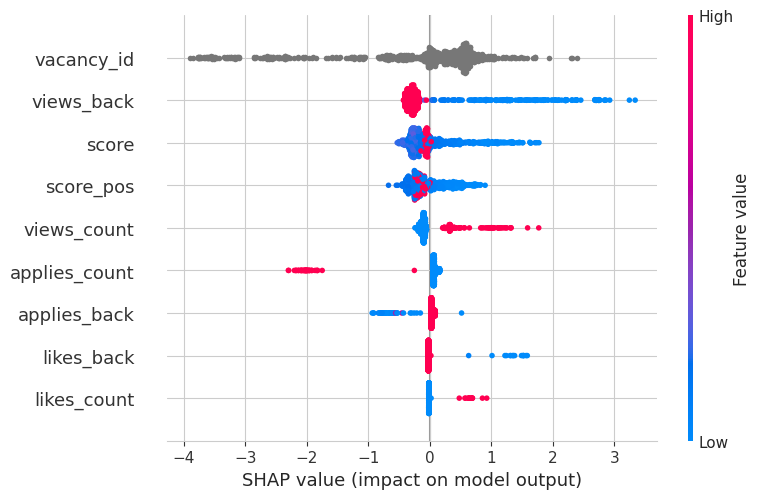

In [96]:
s = test.sample(n=1000).reset_index(drop=True)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(s[ranker_features])

shap.summary_plot(
    shap_values,
    feature_names=ranker_features,
    features=s[ranker_features],
)

In [97]:
model.save_model('../data/model.cbm')

In [111]:
data = pl.read_parquet('../data/final_application_dataset.pq')
data.head()

user_id,vacancy_id,likes_count,applies_count,views_count,likes_back,applies_back,views_back,score,score_pos
str,str,u32,u32,u32,i64,i64,i64,f32,i64
"""u_559119""","""v_1284696""",0,0,0,1000,1000,1000,-1.904106,0
"""u_559119""","""v_113178""",0,0,0,1000,1000,1000,-1.828748,1
"""u_559119""","""v_193151""",0,0,0,1000,1000,1000,-1.827823,2
"""u_559119""","""v_118679""",0,0,0,1000,1000,1000,-1.809671,3
"""u_559119""","""v_234399""",0,0,0,1000,1000,1000,-1.802524,4


In [131]:
import tqdm
batch_size = 1_000_000
scores = []
for batch in tqdm.tqdm(data.iter_slices(n_rows=batch_size), total=len(data) // 1_000_000 + 1):
    batch = batch
    scores.append(pl.select(
        batch['user_id'],
        batch['vacancy_id'],
        pl.Series(model.predict(batch.to_pandas()[ranker_features])).alias('score')
    ))
scores = pl.concat(scores)

100%|██████████████████████████████| 20/20 [00:17<00:00,  1.13it/s]


In [135]:
cb = scores.sort('score', descending=True).group_by(
    'user_id'
).agg(
    pl.col('score'),
    pl.col('vacancy_id').alias('predictions')
)
cb.head()

user_id,score,predictions
str,list[f64],list[str]
"""u_1019168""","[4.415834, 3.196199, … -4.768821]","[""v_2671676"", ""v_39646"", … ""v_338742""]"
"""u_1053295""","[3.626854, 3.532404, … -4.633625]","[""v_2319753"", ""v_96557"", … ""v_100019""]"
"""u_1097576""","[5.04008, 4.738638, … -2.775937]","[""v_1185795"", ""v_372548"", … ""v_1753672""]"
"""u_128158""","[3.684149, 3.461011, … -4.081993]","[""v_1925946"", ""v_1980004"", … ""v_14258""]"
"""u_154422""","[3.532404, 3.196199, … -1.812623]","[""v_724153"", ""v_2478519"", … ""v_366919""]"


In [139]:
cb.shape

(83189, 3)

In [1]:
import polars as pl

In [7]:
p = pl.read_parquet('../data/dssm_test_prediction.pq')

In [10]:
p.shape

(109586, 3)

In [24]:
log = pl.concat([
    pl.read_parquet('../data/hh_recsys_train_hh.pq').with_columns(
        session_end=pl.col('action_dt').list.max(),
    ),
    pl.read_parquet('../data/hh_recsys_test_hh.pq').with_columns(
        session_end=pl.col('action_dt').list.max(),
    ),
])
log = log.join(
    pl.read_parquet('../data/dssm_train.pq').select(
        pl.col('session_id'),
    ).unique(),
    on='session_id',
    how='anti',
)

In [29]:
targets = pl.concat([
    pl.read_parquet('../data/hh_recsys_train_hh.pq').with_columns(
        session_end=pl.col('action_dt').list.max(),
    ),
    pl.read_parquet('../data/hh_recsys_test_hh.pq').with_columns(
        session_end=pl.col('action_dt').list.max(),
    ),
]).select(
    pl.col('user_id'),
    pl.col('vacancy_id'),
    pl.col('action_type'),
    pl.col('session_end'),
).group_by(
    'user_id',
).agg(
    pl.all().sort_by('session_end').last(),
    pl.count(),
).filter(
    pl.col('count') > 1,
).explode(
    ['vacancy_id', 'action_type'],
).filter(
    pl.col('action_type') == 1,
).group_by(
    'user_id',
).agg(
    pl.col('vacancy_id').alias('target'),
    pl.col('session_end').first(),
).select(
    pl.col('user_id'),
    pl.col('target'),
    pl.col('session_end').cast(pl.Date).alias('dt'),
    pl.col('user_id').str.slice(2).cast(pl.UInt64).mod(7).eq(0).alias('is_test'),
)

In [30]:
targets

user_id,target,dt,is_test
str,list[str],date,bool
"""u_1029138""","[""v_856424"", ""v_977462"", ""v_1798221""]",2023-11-14,false
"""u_534249""","[""v_9504"", ""v_575426"", … ""v_1435531""]",2023-11-06,false
"""u_1035507""","[""v_1054439""]",2023-11-13,false
"""u_345492""","[""v_1193361""]",2023-11-01,true
"""u_501445""","[""v_413752"", ""v_1464050"", … ""v_2455488""]",2023-11-20,true
"""u_1084723""","[""v_539939""]",2023-11-21,false
"""u_116775""","[""v_1600015"", ""v_62319""]",2023-11-21,false
"""u_518264""","[""v_2617636""]",2023-11-14,false
"""u_879794""","[""v_1890649""]",2023-11-13,false


In [12]:
p = pl.read_parquet('../data/catboost_predictions_v4.pq')

In [13]:
p.shape

(83189, 2)

In [13]:
x = pl.read_parquet('../data/catboost_predictions_v5.pq')

In [10]:
x.shape

(83189, 2)

In [14]:
x.join(p, on='user_id').select(
    pl.col('predictions').list.first() == pl.col('predictions_right').list.first()
).mean()

predictions
f64
0.794516


In [38]:
x['predictions'].list.len().std()

0.0

In [148]:
len(x.explode('predictions'))

8318900

In [149]:
len(x.explode('predictions').unique())

8318900

In [6]:
import polars as pl

In [ ]:
pl.read_parquet('../data/dssm_prediction.pq').head(2)

In [4]:
test = pl.read_parquet('../data/dssm_test_prediction.pq')
len(test)

348698

In [3]:
pl.read_parquet('../data/dssm_train.pq').shape

(348698, 8)

In [7]:
v = pl.read_parquet('../data/dssm_test_prediction.pq')
v.head(2)

dssm,dssm_distances,user_id
list[str],list[f32],str
"[""v_1948332"", ""v_550082"", … ""v_2504492""]","[-1.825125, -1.820148, … -1.616616]","""u_47163"""
"[""v_1243739"", ""v_454077"", … ""v_8041""]","[-3.027285, -2.964613, … -2.507476]","""u_531617"""


In [10]:
v.select(
    pl.col('dssm').list.len(),
    pl.col('dssm_distances').list.len(),
).min()

dssm,dssm_distances
u32,u32
300,300


In [1]:
import polars as pl

In [2]:
%%time
log = pl.concat([
    pl.read_parquet('../data/hh_recsys_train_hh.pq').with_columns(
        session_end=pl.col('action_dt').list.max(),
    ),
    pl.read_parquet('../data/hh_recsys_test_hh.pq').with_columns(
        session_end=pl.col('action_dt').list.max(),
    ),
])
log.head(2)

CPU times: user 11.8 s, sys: 2.79 s, total: 14.6 s
Wall time: 6.42 s


user_id,session_id,vacancy_id,action_type,action_dt,session_end
str,str,list[str],list[i64],list[datetime[ns]],datetime[ns]
"""u_332060""","""s_28301374""","[""v_2571684"", ""v_488179"", … ""v_2633899""]","[2, 2, … 2]","[2023-11-01 00:40:58.105, 2023-11-01 00:58:13.091, … 2023-11-01 01:35:54.456]",2023-11-01 01:50:26.158
"""u_1057881""","""s_33868982""","[""v_665861""]",[2],[2023-11-01 00:23:51.452],2023-11-01 00:23:51.452


In [10]:
%%time
# dssm = pl.read_parquet('../data/dssm_random_prediction.pq').explode(
dssm = pl.read_parquet('../data/dssm_cosine_prediction.pq').explode(
# dssm = pl.read_parquet('../data/dssm_prediction.pq').explode(
    'dssm', 'dssm_distances'
).select(
    'user_id',
    pl.col('dssm').alias('vacancy_id'),
    pl.col('dssm_distances').alias('d'),
    pl.col('dssm').str.slice(2).cast(pl.UInt64).add(1).alias('vid'),
)
dssm.head(2)

CPU times: user 1min 18s, sys: 31.5 s, total: 1min 49s
Wall time: 1min 11s


user_id,vacancy_id,d,vid
str,str,f32,u64
"""u_2382""","""v_811602""",1.424253,811603
"""u_2382""","""v_38852""",1.42628,38853


In [8]:
%%time
dssm = pl.read_parquet('../data/fm_prediction.pq').explode(
    'fm', 'fm_distances'
).select(
    'user_id',
    pl.col('fm').alias('vacancy_id'),
    pl.col('fm_distances').alias('d'),
)
dssm.head(2)

CPU times: user 1min 23s, sys: 36.5 s, total: 2min
Wall time: 48.1 s


user_id,vacancy_id,d
str,str,f32
"""u_117268""","""v_687668""",0.111917
"""u_117268""","""v_1300481""",0.118953


In [9]:
%%time
needed = pl.read_parquet('../data/hh_recsys_test_hh.pq').select('user_id').unique()
log = log.join(needed, on='user_id', how='semi')
dssm = dssm.join(needed, on='user_id', how='semi')


CPU times: user 15.8 s, sys: 9.05 s, total: 24.9 s
Wall time: 3.69 s


In [10]:
h = log.explode(
    'vacancy_id',
    'action_type',
    'action_dt',
).group_by(
    'user_id',
    'vacancy_id',
).agg(
    pl.col('action_type').min(),
    pl.col('action_dt').max(),
).select(
    pl.all(),
    pl.col('vacancy_id').str.slice(2).cast(pl.UInt64).add(1).alias('vid'),
)
h.head(2)

user_id,vacancy_id,action_type,action_dt,vid
str,str,i64,datetime[ns],u64
"""u_786220""","""v_2727929""",2,2023-11-01 00:56:31.573,2727930
"""u_639152""","""v_1050141""",2,2023-11-06 23:10:58.513,1050142


In [11]:
%%time
full = h.join(
    dssm,
    on=['user_id', 'vacancy_id'],
    how='outer_coalesce',
).select(
    pl.exclude('action_dt', 'action_type', 'd'),
    pl.col('d').fill_null(100),
    pl.col('action_type').cast(pl.Float32).fill_null(1.5),
    pl.col('action_dt').fill_null(pl.datetime(2025, 1, 1)),
)
full.head(2)

CPU times: user 28.5 s, sys: 4.67 s, total: 33.2 s
Wall time: 25.6 s


user_id,vacancy_id,vid,d,action_type,action_dt
str,str,u64,f32,f32,datetime[μs]
"""u_253180""","""v_892358""",null,0.08405,1.5,2025-01-01 00:00:00
"""u_253180""","""v_1592870""",null,0.096936,1.5,2025-01-01 00:00:00


In [12]:
full.filter(
    pl.col('action_type') >= 2
).group_by(
    'user_id',
).agg(
    pl.col('d').ne(100).mean(),
    pl.count(),
).select(
    pl.col('d') > 0
).mean()

d
f64
0.831445


In [14]:
full.filter(
    pl.col('action_type') >= 2
).group_by(
    'user_id',
).agg(
    pl.col('d').ne(100).mean(),
    pl.count(),
).select(
    pl.col('d') > 0
).mean()

d
f64
0.261094


In [8]:
full.filter(
    pl.col('action_type') >= 2
).group_by(
    'user_id',
).agg(
    pl.col('d').ne(100).mean(),
    pl.count(),
).select(
    pl.col('d') > 0
).mean()

d
f64
0.059708


In [23]:
full.filter(
    pl.col('action_type') >= 2
).group_by(
    'user_id',
).agg(
    pl.col('d').ne(100).mean(),
    pl.count(),
).select(
    pl.col('d') > 0
).mean()

d
f64
0.026327


In [13]:
full.filter(
    pl.col('action_type') >= 2
).select(
    pl.col('d') < 100
).mean()

d
f64
0.206905


In [15]:
full.filter(
    pl.col('action_type') >= 2
).select(
    pl.col('d') < 100
).mean()

d
f64
0.022784


In [9]:
full.filter(
    pl.col('action_type') >= 2
).select(
    pl.col('d') < 100
).mean()

d
f64
0.002542


In [15]:
full.filter(
    pl.col('action_type') >= 2
).select(
    pl.col('d') < 100
).mean()

d
f64
0.000908


In [52]:
full.filter(
    pl.col('action_type') >= 2
).select(
    pl.col('d') < 100
).mean()

d
f64
0.000139


In [47]:
full.filter(
    pl.col('action_type') >= 2
).select(
    pl.col('d') < 100
).mean()

d
f64
0.001505


In [41]:
full.filter(
    pl.col('action_type') == 3
).select(
    pl.col('d') < 100
).mean()

d
f64
0.002386


In [34]:
full.filter(
    pl.col('action_type') == 3
).select(
    pl.col('d') < 100
).mean()

d
f64
0.006432


In [14]:
simple = full.sort(
    ['user_id', 'action_type', 'action_dt', 'd'],
    descending=[False, True, True, False],
).group_by(
    'user_id'
).agg(
    pl.col('vacancy_id').head(100),
).select(
    'user_id',
    pl.col('vacancy_id').alias('predictions'),
)
simple.head(5)

user_id,predictions
str,list[str]
"""u_895122""","[""v_2492783"", ""v_1453506"", … ""v_1095821""]"
"""u_428199""","[""v_636548"", ""v_2256163"", … ""v_1562024""]"
"""u_873746""","[""v_256221"", ""v_1258364"", … ""v_1885723""]"
"""u_877963""","[""v_149774"", ""v_643685"", … ""v_1924850""]"
"""u_940546""","[""v_1185290"", ""v_1835938"", … ""v_2539057""]"


In [17]:
x.join(simple, on='user_id').select(
    pl.col('predictions').list.first() == pl.col('predictions_right').list.first()
).mean()

NameError: name 'x' is not defined

In [15]:
simple.write_parquet('../data/simple_pred_fm.pq')

In [28]:
v = pl.read_parquet('../data/vacancy_features.pq').sort('vacancy_id')
v.head(2)

vacancy_id,area.regionId,area.id,company.id,workSchedule,employment,workExperience,compensation.currencyCode,name
u64,u64,u64,u64,u64,u64,u64,u64,u64
1,46,2650,131950,5,1,1,10,8414
2,30,4102,141310,4,1,1,10,11793


In [29]:
v.shape

(2734129, 9)

In [30]:
v['vacancy_id'].unique().shape

(2734129,)